In [11]:
%matplotlib inline
from PIL import Image
from PIL import ImageFilter
import pytesseract
import matplotlib.pyplot as plt
import cv2 
import numpy as np
from collections import defaultdict
import os
import time

class Languages:
    CHS = 'chi_sim'
    CHS_V = "chi_sim_vert"
    CHT = 'chi_tra'
    CHT_V = 'chi_tra_vert'
    CHT_CHS = "chi_tra+chi_sim"
    ENG = 'eng'

class OCR( ):
    @classmethod
    def pil_2_cv(cls,img_pil_rgb):     
        img_cv_bgr = Image.fromarray(cv2.cvtColor(img_pil_rgb,cv2.COLOR_BGR2RGB))
        return img_cv_bgr
    @classmethod
    def cv_2_pil(cls,img_cv_bgr):
        img_pil_rgb = cv2.cvtColor(np.asarray(img_cv_bgr),cv2.COLOR_RGB2BGR)  
        return img_pil_rgb
    @classmethod
    def cv2_BGR2model(cls,img_cv_bgr,mode):
        """mode = cv2.COLOR_BGR2LAB、cv2.COLOR_BGR2HSV、cv2.COLOR_BGR2GRAY..."""
        img_cv = cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2LAB)
        return img_cv
    @classmethod
    def ColourDistance(cls,rgb_1, rgb_2):
        R_1,G_1,B_1 = rgb_1
        R_2,G_2,B_2 = rgb_2
        rmean = (R_1 +R_2 ) / 2
        R = R_1 - R_2
        G = G_1 -G_2
        B = B_1 - B_2
        return math.sqrt((2+rmean/256)*(R**2)+4*(G**2)+(2+(255-rmean)/256)*(B**2))

    
    def get_base(self,image):
        # 按照閥值進行二值化處理
        # 獲取灰度圖片中像素點數量最多的像素
        pixel_dict = defaultdict(int)
        # 像素及該像素出现次數的字典
        rows, cols = image.size
        for i in range(rows):
            for j in range(cols):
                pixel = image.getpixel((i, j))
                pixel_dict[pixel] += 1
        base = max(pixel_dict,key=pixel_dict.get)
        return base
    
    def get_bin_table_easy(self,threshold):
        table = []
        for i in range(256):
            if i < threshold:
                table.append(0)
            else:
                table.append(1)
        return table
    
    # base: 顏色基準值(灰度圖為某一亮度，彩圖為某一顏色)
    def get_bin_table(self,base,threshold):
        """
        base: 顏色基準值(灰度圖為某一亮度，彩圖為某一顏色)
        threshold: 閥值
        """
        # 获取灰度转二值的映射table
        table = []
        for i in range(256):
            rate = threshold # 在threshold的适当范围内进行处理
            if base*(1-rate)<= i <= base*(1+rate):
                table.append(1)
            else:
                table.append(0)
        return table

    # 去掉二值化处理后的图片中的噪声点
    def cut_noise(self,image):
        rows, cols = image.size # 图片的宽度和高度
        change_pos = [] # 记录噪声点位置
        # 遍历图片中的每个点，除掉边缘
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                # pixel_set用来记录该店附近的黑色像素的数量
                pixel_set = []
                # 取该点的邻域为以该点为中心的九宫格
                for m in range(i-1, i+2):
                    for n in range(j-1, j+2):
                        if image.getpixel((m, n)) != 1: # 1为白色,0位黑色
                            pixel_set.append(image.getpixel((m, n)))
                # 如果该位置的九宫内的黑色数量小于等于4，则判断为噪声
                if len(pixel_set) <= 1:
                    change_pos.append((i,j))
        # 对相应位置进行像素修改，将噪声处的像素置为1（白色）
        for pos in change_pos:
            image.putpixel(pos, 1)
        return image # 返回修改后的图片

    def img_preprocess(self,image):
        imgry = image.convert('L')  # 转化为灰度图
        # 获取图片中的出现次数最多的像素，即为该图片的背景
        max_pixel = self.get_base(imgry)
        # 將圖片依閥值轉為0,1的table
        table = self.get_bin_table(base=max_pixel,threshold=0.2)
#         table = self.get_bin_table_easy(180)
        #將圖片依照table進行二值化處理
        out = imgry.point(table, '1')
        # 去掉图片中的噪声（孤立点）
#         out = self.cut_noise(out)
#         out = imgry
        return out
    
    def img_to_str(self,image, lang):
        #--oem 選擇傳統或LSTM模式，--psm 選擇"分頁"(單字符或多字符辨識)
        text = pytesseract.image_to_string(image, lang,config="--oem 0 --psm 10")    
        return text

    def img_to_str_(self,image,lang,clean_symbol=False):
        # 仅识别图片中的数字
        #text = pytesseract.image_to_string(out, config='digits')
        # 识别图片中的数字和字母
        text = pytesseract.image_to_string(image,lang)
        # 去掉识别结果中的特殊字符
        if clean_symbol == True:
            exclude_char_list = ' .:\\|\'\"?![],()~@#$%^&*_+-={};<>/¥'
            text = ''.join([x for x in text if x not in exclude_char_list])
        #print(text)
        return text

    def start_ocr(self,dir_path,file_name,lang):
        """
        OCR對bmp,tif檔準確性較高，dpi建議為300
        lang:OCR language
        
        """
        file_path = os.path.join(dir_path,file_name)
        pre, ext = os.path.splitext(file_name)
        save_path = os.path.join(dir_path,"new_"+pre+".png")        
        im = Image.open(file_path)
        im =  im.convert('RGB')
        im.save(save_path,dpi=(300,300))
        
        im = Image.open(save_path)
        im = im.filter(ImageFilter.EDGE_ENHANCE)
        im = im.transpose(Image.ROTATE_270)
        crop_config = (np.array((120,20,145,55))).astype(np.int)
#         crop_config = (np.array((85,0,110,35))).astype(np.int)        
        im = im.crop(crop_config)        
        im.save(save_path,format="PNG",optimize=False,compress_level=0,dpi=(300,300))
        im1 = Image.open(save_path)
        im1 = self.img_preprocess(im)
        print(self.img_to_str(im1, lang=lang))
        return im1

# def pil_function():
a = time.time()
ocr = OCR()
dir_path = r"D:\Backup\ml_data\GitHub\play\pipe_file\orc_test"
file_name = "2.png"
lang =Languages.CHT
im1 = ocr.start_ocr(dir_path,file_name,lang)
b = time.time()

蔓


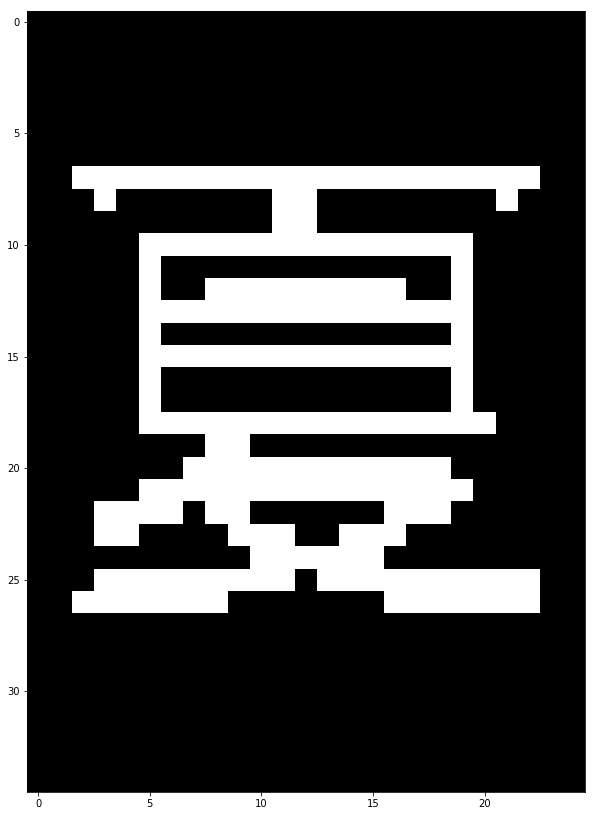

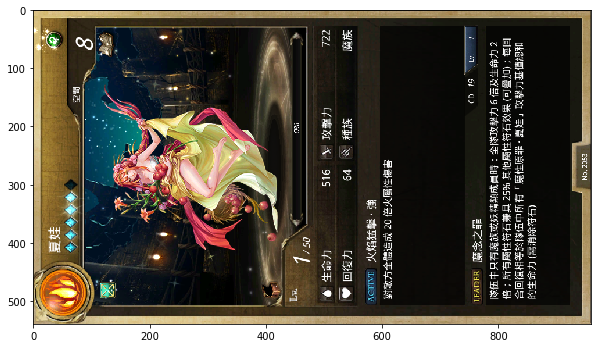

In [7]:
im_array = np.asarray(im1)
plt.figure(figsize=(10,20))
plt.imshow(im_array,cmap="gray")
file_path = os.path.join(dir_path,file_name)
im = Image.open(file_path)
im_array = np.asarray(im)
plt.figure(figsize=(10,20))
plt.imshow(im_array,cmap="gray")

In [8]:
from collections import defaultdict

pixel_dict = {(0,0,0):10,(100,100,100):1,(50,50,50):25}
# {v:k for k,v in pixel_dict.items()}


(50, 50, 50)